# Proof of concept: the Two-SNP example

Here I pick up a particular data-set and make a very specific simulation case:

1. In data I find SNPs with -0.8 correlations
2. I then simulate for one SNP to be associated with 3 phenotypes, and the other to be associated with the rest, both with fixed positive effect size

[See here](https://github.com/stephenslab/gtexresults/blob/master/workflows/2SNP.ipynb) for motivation of the analysis.

In [1]:
%cd /home/gaow/tmp/13-May-2019

/home/gaow/Documents/TempDir/13-May-2019

## Find negatively correlation SNPs

In [2]:
genotype = readRDS('Multi_Tissues.ENSG00000145214.RDS')$X

In [3]:
ld = cor(genotype)

In [17]:
idx = which(ld > -0.855 & ld < -0.85, arr.ind = T)

In [5]:
head(idx)

,row,col
chr4_173807_A_G_b38,354,184
chr4_205767_C_CA_b38,454,184
chr4_205769_C_T_b38,455,184
chr4_196264_A_G_b38,417,233
chr4_196753_C_T_b38,420,266
chr4_199265_C_G_b38,427,293


So let's check out 184 and 354:

In [6]:
cor(genotype[,184], genotype[,354])

[1] -0.854587

In [7]:
colnames(genotype)[184]

[1] "chr4_112523_C_T_b38"

In [8]:
colnames(genotype)[354]

[1] "chr4_173807_A_G_b38"

## Simulate multivariate phenotypes

In [9]:
P = ncol(genotype)
R = 6
eff_factor = 1.5

In [10]:
set.seed(1)
b = matrix(0, P, R)
sharing = matrix(0.75, 3, 3)
diag(sharing) = 1

In [11]:
b[184, 1:3] = abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
b[354, 4:6] = abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
print(b[184, 1:3])
print(b[354, 4:6])

[1] 0.1951948 0.3530102 0.5955379
[1] 1.136650 1.039006 0.736915


In [12]:
g = genotype %*% b

In [13]:
apply(g,2,sd) * eff_factor

[1] 0.2022533 0.3657754 0.6170732 1.1705304 1.0699760 0.7588805

In [14]:
e = MASS::mvrnorm(1, rep(0,R), diag(R) * 1)

In [15]:
Y = g + e

## Prepare MASH mixture prior

In [16]:
U1 = matrix(0,R,R)
U1[1:3,1:3] = sharing
U2 = matrix(0,R,R)
U2[4:6,4:6] = sharing
Ulist = list(U1=U1, U2=U2)
scaling = c(0.5,1) / eff_factor
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 1)

## Fit MV-SuSiE

In [18]:
res = mmbr::susie(genotype,Y,
                  L=10,V=mash_init,
                  compute_objective=FALSE)

In [19]:
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))

In [20]:
rownames(res$coef) = c('intercept', snps)

## Visualize results

In [21]:
pdf('susie_plot_toy.pdf', width=8, height=4)
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)
dev.off()

png 
  2

In [22]:
p = mmbr::mmbr_plot(res)

Suggested PDF canvas width: 9.5 height: 5.4 


In [23]:
pdf('mmbr_plot_toy.pdf', width = 8, height = 4)
print(p$plot)
dev.off()

png 
  2

> susie_plot_toy.pdf (25.8 KiB):

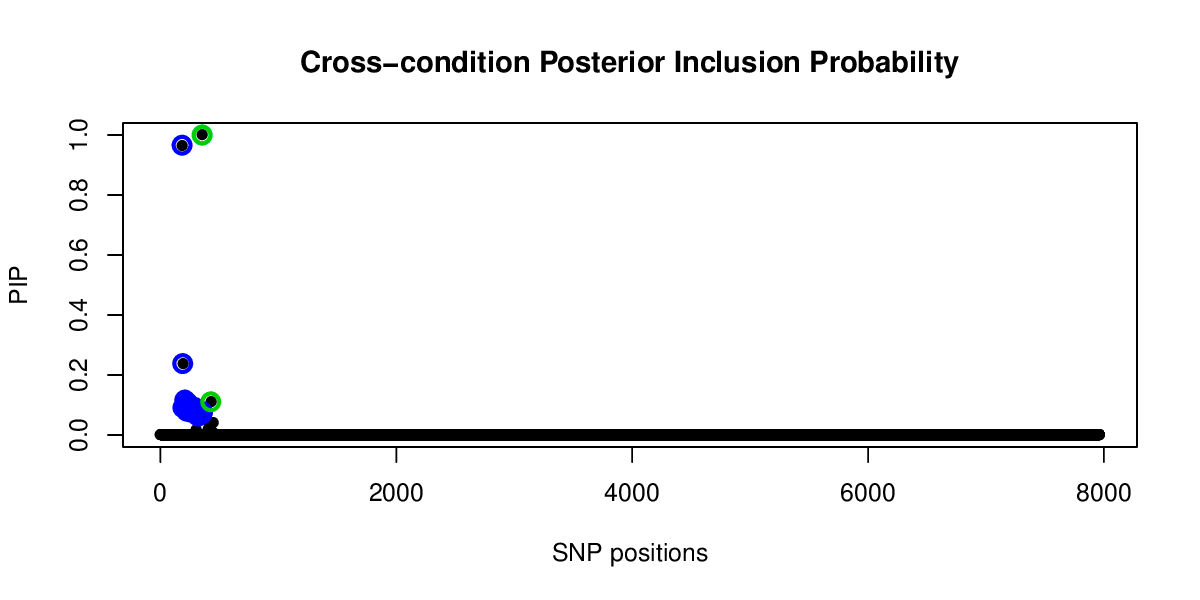

In [24]:
%preview susie_plot_toy.pdf -s png --dpi 150

> mmbr_plot_toy.pdf (5.7 KiB):

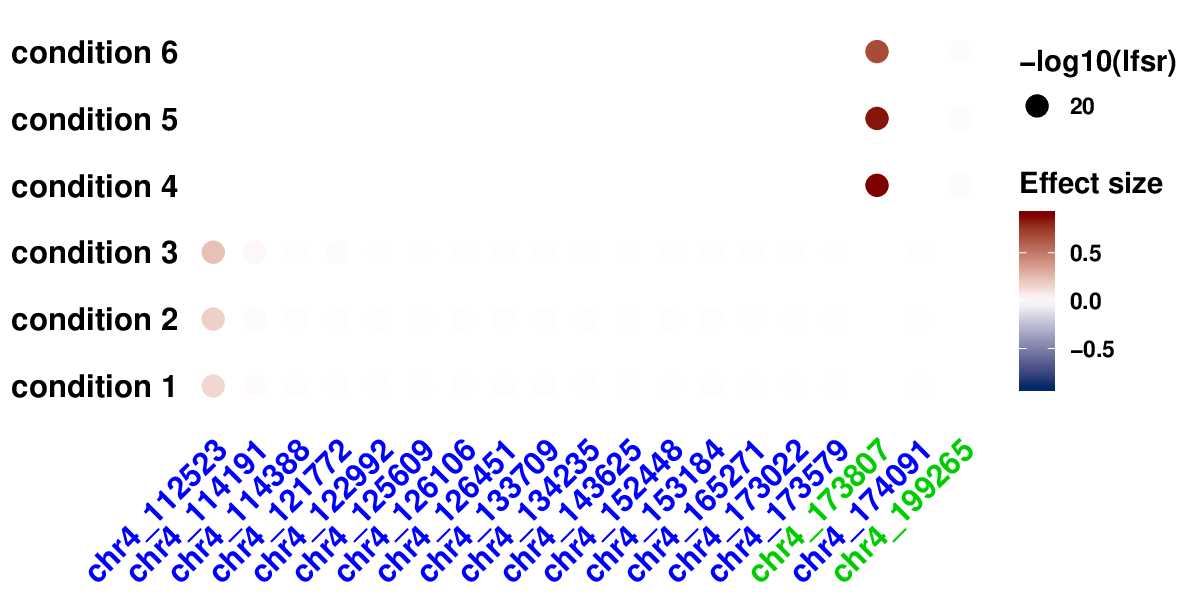

In [25]:
%preview mmbr_plot_toy.pdf -s png --dpi 150

For original effect size,

In [28]:
univariate_res = lapply(1:ncol(Y), function(i) susieR:::univariate_regression(genotype,Y[,i]))
res$bhat = do.call(cbind, lapply(1:ncol(Y), function(i) univariate_res[[i]]$betahat))
res$shat = do.call(cbind, lapply(1:ncol(Y), function(i) univariate_res[[i]]$sebetahat))

In [31]:
rownames(res$bhat) = snps
p = mmbr::mmbr_plot(res, original_sumstat = TRUE)

Suggested PDF canvas width: 9.5 height: 5.4 


In [34]:
pdf('mmbr_plot_toy_original.pdf', width = 8, height = 4.5)
print(p$plot)
dev.off()

png 
  2

> mmbr_plot_toy_original.pdf (7.3 KiB):

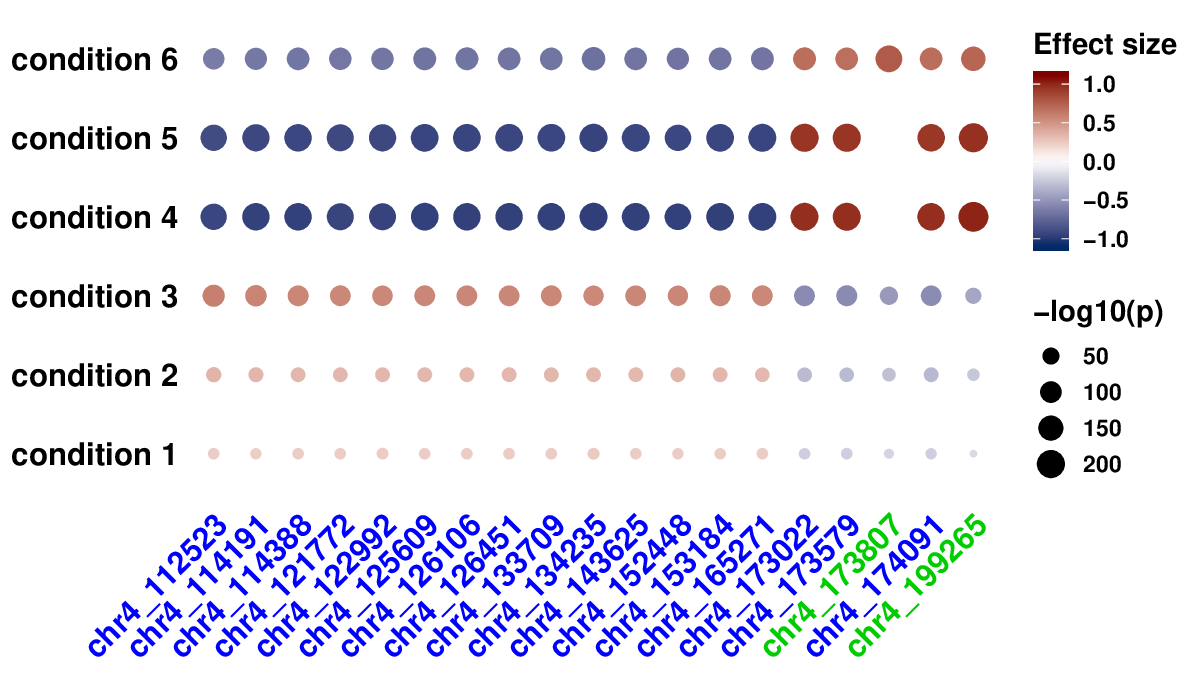

In [35]:
%preview mmbr_plot_toy_original.pdf -s png --dpi 150